# Noise2Self-inspired Optopatch moving denoising

In [1]:
%matplotlib inline

import os
import sys
notebook_path = os.path.abspath('.')
sources_path = os.path.abspath(os.path.join(notebook_path, '..'))
sys.path.insert(0, sources_path)

import matplotlib.pylab as plt
import numpy as np
from time import time
import torch
import logging
import json
import pprint

from cellmincer.opto_ws import OptopatchBaseWorkspace, OptopatchDenoisingWorkspace
from cellmincer.opto_utils import crop_center, get_nn_spatio_temporal_mean, get_nn_spatial_mean
from cellmincer.opto_denoise import get_minimum_padding
from cellmincer.opto_denoise import UNet, \
    generate_occluded_training_data, get_loss_end_to_end, \
    generate_input_for_single_frame_denoising, \
    denoise_end_to_end

device = torch.device("cuda")
dtype = torch.float32

def new_fig(figsize=(15, 5)):
    fig = plt.figure(figsize=figsize)
    ax = plt.gca()
    return fig, ax

logger = logging.getLogger()

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark = True

In [2]:
from contextlib import contextmanager

@contextmanager
def evaluating(net):
    '''Temporarily switch to evaluation mode.'''
    istrain = net.training
    try:
        net.eval()
        yield net
    finally:
        if istrain:
            net.train()
    
def generate_denoised_movie(
        ws_base_list,
        ws_denoising_list,
        end_to_end_denoiser,
        i_dataset,
        i_t_begin,
        i_t_end,
        x0,
        y0,
        x_window,
        y_window):

    denoised_movie_txy = np.zeros(
        (i_t_end - i_t_begin, ws_base_list[0].width, ws_base_list[0].height),
        dtype=np.float32)

    with evaluating(end_to_end_denoiser):
        
        for i_t in range(i_t_begin, i_t_end):

            denoising_input_data = generate_input_for_single_frame_denoising(
                ws_base_list=ws_base_list,
                ws_denoising_list=ws_denoising_list,
                i_dataset=i_dataset,
                i_t=i_t,
                t_order=denoiser_config['t_order'],
                x0=x0,
                y0=y0,
                x_window=x_window,
                y_window=y_window,
                device=device,
                dtype=dtype)

            denoised_frame_xy = denoise_end_to_end(
                denoising_input_data,
                ws_base_list=ws_base_list,
                ws_denoising_list=ws_denoising_list,
                end_to_end_denoiser=end_to_end_denoiser)

            denoised_movie_txy[
                i_t - i_t_begin,
                x0:(x0 + x_window),
                y0:(y0 + y_window)] = denoised_frame_xy.cpu().numpy()

    return denoised_movie_txy


def get_denoised_movie_sma_txy(denoised_movie_txy_list):
    n_movies = len(denoised_movie_txy_list)
    denoised_movie_sma_txy = denoised_movie_txy_list[0].copy() / n_movies
    for denoised_movie_txy in denoised_movie_txy_list[1:]:
        denoised_movie_sma_txy += (denoised_movie_txy / n_movies)
    return denoised_movie_sma_txy


def save_model_state(model_root, model_prefix, index, save_adam_state=True):
    full_model_prefix = f'{model_prefix}__{index:06d}'
    with open(os.path.join(model_root, f'denoiser_config__{full_model_prefix}.json'), 'w') as f:
        json.dump(denoiser_config, f)
    torch.save(
        end_to_end_denoiser.state_dict(),
        os.path.join(model_root, f'end_to_end_denoiser__{full_model_prefix}.pt'))
    if save_adam_state:
        torch.save(
            optim.state_dict(),
            os.path.join(model_root, f'adam_state__{full_model_prefix}.pt'))


def load_model_state(model_root, model_prefix, index):
    model_path = os.path.join(model_root, f'end_to_end_denoiser__{model_prefix}__{index:06d}.pt')
    return torch.load(model_path)


def get_swa_state_dict(model_root, model_prefix, begin_index, end_index):
    first_state = load_model_state(model_root, model_prefix, begin_index)
    keys = list(first_state.keys())

    ave_state = first_state
    n_summed = 1
    for index in range(begin_index + 1, end_index):
        try:
            c_state = load_model_state(model_root, model_prefix, index)
        except:
            continue
            
        for key in keys:
            ave_state[key] += c_state[key]

        n_summed += 1

    for key in keys:
        ave_state[key] /= n_summed
        
    return ave_state


def smooth_list(values, smoothing_window):
    if len(values) < smoothing_window:
        return np.mean(values)
    else:
        return np.mean(values[-smoothing_window:])

## Configuration

In [3]:
# list of Optopatch movies
opto_mov_path_list = [
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D1_FOV3_W2_at135105.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy',
    '/home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy'
]

# names
opto_mov_prefixes = [
    'D1_FOV3_W2_at135105',
    'D4_FOV2_W2_at171603',
    'D4_FOV3_W2_at172029',
    'E3_FOV1_W2_at155440',
    'F1_FOV2_W1_at143005'
]

# output
output_path = '/home/jupyter/mb-ml-dev-disk/data/Optopatch/denoised_data'
model_root = '/home/jupyter/mb-ml-dev-disk/CellMincer/saved_models'

if not os.path.exists(output_path):
    os.mkdir(output_path)
    
if not os.path.exists(model_root):
    os.mkdir(model_root)

### Model config

In [13]:
model_prefix = 'rc1_t15__unreg'
old_model = True
denoiser_config_path = os.path.join(model_root, f'denoiser_config__{model_prefix}__000000.json')

denoiser_config_path = None

if denoiser_config_path is None:
    # this configuration requires 16gb of GPU memory (e.g. Tesla V100)
    denoiser_config = {
        'n_unet_blocks': 1,
        'unet_depth': 3,  # depth of a unet per-frame feature extractor
        'unet_wf': 5,  # log number of unet filters in the first layer
        'unet_out_channels_before_readout': 32,
        'unet_readout_hidden_layer_channels_list': [32, 32, 32],
        'unet_readout_kernel_size': 1,
        'unet_kernel_size': 3,
        't_order': 7,  # denoising filter taps
        'occlusion_prob': 0.05,  # fraction of pixels to occlude during training
        'occlusion_strategy': 'random',  # how to occlude?
        'batch_norm': False,  # enable batch norm (False)
    }
else:
    logging.warning(f'Loading denoising model configuration from {denoiser_config_path} ...')
    with open(denoiser_config_path, 'r') as f:
        denoiser_config = json.load(f)
        
    # for old models, we need to add something to the config:
    if old_model:
        denoiser_config['unet_out_channels_before_readout'] = 2 ** denoiser_config['unet_wf']
        
    pprint.pprint(denoiser_config)

In [14]:
final_x_window = 96
final_y_window = 96

c_x_window = final_x_window
c_y_window = final_y_window
for i_unet in range(denoiser_config['n_unet_blocks']):
    x_padding, y_padding = get_minimum_padding(
        x_window=c_x_window,
        y_window=c_y_window,
        denoiser_config=denoiser_config)
    c_x_window = c_x_window + 2 * x_padding
    c_y_window = c_y_window + 2 * y_padding

x_padding = (c_x_window - final_x_window) // 2
y_padding = (c_y_window - final_y_window) // 2

print(f'x-padding: {x_padding}px')
print(f'y-padding: {y_padding}px')

assert denoiser_config['t_order'] > 0 and denoiser_config['t_order'] % 2 == 1
assert 0. < denoiser_config['occlusion_prob'] < 1.0

x-padding: 62px
y-padding: 62px


## Load datasets

In [15]:
# setup datasets
ws_base_list = []
for opto_mov_path in opto_mov_path_list:
    ws_base_list.append(OptopatchBaseWorkspace(opto_mov_path, logger))
n_datasets = len(ws_base_list)

ws_denoising_list = []
for ws_base in ws_base_list:
    ws_denoising = OptopatchDenoisingWorkspace(ws_base, x_padding, y_padding)
    ws_denoising_list.append(ws_denoising)

Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D1_FOV3_W2_at135105.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV2_W2_at171603.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/D4_FOV3_W2_at172029.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/E3_FOV1_W2_at155440.npy ...
Loading movie from /home/jupyter/mb-ml-dev-disk/data/Optopatch/sami_data/F1_FOV2_W1_at143005.npy ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...
Calculating temporal correlation with neighbors ...
Calculating zero-mean movie ...
Calculating temporal mean ...
Calculating temporal std ...
Calculating temporal correlation with

## Instantiate the denoising model

In [16]:
class SerialUNetDenoiser(torch.nn.Module):
    def __init__(self, denoiser_config):
        super(SerialUNetDenoiser, self).__init__()
        unet_blocks = []

        # initial input channels
        prev_out_channels =  ws_denoising_list[0].n_global_features + denoiser_config['t_order']
        for i_unet in range(denoiser_config['n_unet_blocks']):
            if i_unet < (denoiser_config['n_unet_blocks'] - 1):
                out_channels = 2 ** denoiser_config['unet_wf']
                skip_readout = True
            else:
                out_channels = 1
                skip_readout = False               
            c_unet = UNet(
                in_channels=prev_out_channels,
                out_channels=out_channels,
                depth=denoiser_config['unet_depth'],
                wf=denoiser_config['unet_wf'], 
                batch_norm=denoiser_config['batch_norm'], 
                unet_kernel_size=denoiser_config['unet_kernel_size'],
                readout_hidden_layer_channels_list=denoiser_config['unet_readout_hidden_layer_channels_list'],
                out_channels_before_readout=denoiser_config['unet_out_channels_before_readout'],
                readout_kernel_size=denoiser_config['unet_readout_kernel_size'],
                activation=torch.nn.ReLU(),
                up_mode='upconv',
                padding=False,
                skip_readout=skip_readout,
                device=device,
                dtype=dtype)
            unet_blocks.append(c_unet)
            prev_out_channels = out_channels
            
        self.seq_unet = torch.nn.Sequential(*unet_blocks)
        
    def forward(self, x):
        return self.seq_unet(x)

In [17]:
# end_to_end_denoiser = UNet(
#     in_channels=ws_denoising_list[0].n_global_features + denoiser_config['t_order'],
#     out_channels=1,
#     depth=denoiser_config['unet_depth'],
#     wf=denoiser_config['unet_wf'], 
#     batch_norm=denoiser_config['batch_norm'], 
#     unet_kernel_size=denoiser_config['unet_kernel_size'],
#     readout_hidden_layer_channels_list=denoiser_config['unet_readout_hidden_layer_channels_list'],
#     out_channels_before_readout=denoiser_config['unet_out_channels_before_readout'],
#     readout_kernel_size=denoiser_config['unet_readout_kernel_size'],
#     activation=torch.nn.ELU(),
#     up_mode='upconv',
#     padding=False,
#     device=device,
#     dtype=dtype)

In [18]:
end_to_end_denoiser = SerialUNetDenoiser(denoiser_config)

In [19]:
end_to_end_denoiser

SerialUNetDenoiser(
  (seq_unet): Sequential(
    (0): UNet(
      (down_path): ModuleList(
        (0): UNetConvBlock(
          (block): Sequential(
            (0): Conv2d(18, 32, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
            (3): ReLU()
          )
        )
        (1): UNetConvBlock(
          (block): Sequential(
            (0): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
            (3): ReLU()
          )
        )
        (2): UNetConvBlock(
          (block): Sequential(
            (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
            (1): ReLU()
            (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
            (3): ReLU()
          )
        )
      )
      (up_path): ModuleList(
        (0): UNetUpBlock(
          (up): ConvTranspose2d(128, 64, kernel_size=

In [20]:
load_model = True
model_prefix_to_load = 'rc2_t11_relu__unreg'
model_index = 10
if load_model:
    logging.warning(f'Loading a pre-trained model ...')
    end_to_end_denoiser.load_state_dict(load_model_state(model_root, model_prefix_to_load, model_index))

In [21]:
# change the model prefix to continue as a new model
model_prefix = 'rc3_t11_relu__unreg'

### Train

In [22]:
total_loss_hist = []
rec_loss_hist = []
denoised_movie_list = []

In [23]:
all_params = end_to_end_denoiser.parameters()
optim = torch.optim.Adam(all_params, lr=1e-4, betas=(0.95, 0.999))

In [24]:
# save results?
enable_save = True

# loss and minibatching config
n_batch = 10
t_tandem = 8
x_window = 96
y_window = 96
norm_p = 1
wd = 0.01

# regularization config
enable_continuity_reg = False
continuity_reg_strength = 1.0
noise_threshold_to_std = 0.05
reg_func = 'clamped_linear'

# training tracking config
n_iters = 20_000
log_every = 10
denoise_every = np.inf
save_every = 1000
smoothing_window = 500

# only if sampling denoised movie is required (denoise_every != np.inf)
i_dataset_denoising = 0
i_t_begin_denoising = 50
i_t_end_denoising = 600
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

end_to_end_denoiser.train()
torch.cuda.empty_cache()

In [25]:
i_iter = 0

In [26]:
if not enable_save:
    logging.warning("-- SAVING IS DISABLED --")

while i_iter < n_iters:
    
    batch_data = generate_occluded_training_data(
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        t_order=denoiser_config['t_order'],
        t_tandem=t_tandem,
        n_batch=n_batch,
        x_window=x_window,
        y_window=y_window,
        occlusion_prob=denoiser_config['occlusion_prob'],
        occlusion_strategy=denoiser_config['occlusion_strategy'],
        continuity_reg_strength=continuity_reg_strength,
        noise_threshold_to_std=noise_threshold_to_std,
        device=device,
        dtype=dtype)
        
    rec_loss, reg_loss = get_loss_end_to_end(
        batch_data=batch_data,
        ws_base_list=ws_base_list,
        ws_denoising_list=ws_denoising_list,
        end_to_end_denoiser=end_to_end_denoiser,
        norm_p=norm_p,
        enable_continuity_reg=enable_continuity_reg,
        reg_func=reg_func)

    if reg_loss is not None:
        total_loss = rec_loss + reg_loss
    else:
        total_loss = rec_loss
    
    optim.zero_grad()
    total_loss.backward()
    for group in optim.param_groups:
        for param in group['params']:
            param.data = param.data.add(-wd * group['lr'], param.data)        
    optim.step()

    loss_scale = batch_data['padded_occlusion_masks_ntxy'].sum().item()
    total_loss_hist.append(total_loss.item() / loss_scale)
    rec_loss_hist.append(rec_loss.item() / loss_scale)
    
    if i_iter % log_every == 0:
        
        print(f"iter: {i_iter}" +
              f", total loss: {smooth_list(total_loss_hist, smoothing_window):.4}" +
              (f", reconstruction loss: {smooth_list(rec_loss_hist, smoothing_window):.4}" if enable_continuity_reg else ""))
        
    if i_iter % denoise_every == 0 and i_iter > 0:
        print("Generating a denoised movie sample...")
        denoised_movie_txy = generate_denoised_movie(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            end_to_end_denoiser=end_to_end_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
        
        denoised_movie_list.append(generate_denoised_movie())
        end_to_end_denoiser.train()
        
    if enable_save and (i_iter % save_every == 0):
        print("Saving...")
        save_model_state(
            model_root=model_root,
            model_prefix=model_prefix,
            index=(i_iter // save_every))
        
    i_iter += 1

iter: 0, total loss: 0.574
Saving...
iter: 10, total loss: 0.578
iter: 20, total loss: 0.5796
iter: 30, total loss: 0.5818
iter: 40, total loss: 0.5814
iter: 50, total loss: 0.5797
iter: 60, total loss: 0.5796
iter: 70, total loss: 0.5801
iter: 80, total loss: 0.5794
iter: 90, total loss: 0.5797
iter: 100, total loss: 0.5797
iter: 110, total loss: 0.5804
iter: 120, total loss: 0.5802
iter: 130, total loss: 0.5798
iter: 140, total loss: 0.5798
iter: 150, total loss: 0.5797
iter: 160, total loss: 0.5799
iter: 170, total loss: 0.5798
iter: 180, total loss: 0.5796
iter: 190, total loss: 0.5798
iter: 200, total loss: 0.5796
iter: 210, total loss: 0.5792
iter: 220, total loss: 0.579
iter: 230, total loss: 0.5788
iter: 240, total loss: 0.5789
iter: 250, total loss: 0.5791
iter: 260, total loss: 0.579
iter: 270, total loss: 0.5791
iter: 280, total loss: 0.5788
iter: 290, total loss: 0.579
iter: 300, total loss: 0.5791
iter: 310, total loss: 0.5789
iter: 320, total loss: 0.579
iter: 330, total 

KeyboardInterrupt: 

In [27]:
if enable_save:
    np.save(os.path.join(model_root, f'total_loss_hist_{model_prefix}.npy'), total_loss_hist)
    np.save(os.path.join(model_root, f'rec_loss_hist_{model_prefix}.npy'), rec_loss_hist)

Text(0, 0.5, 'loss per pixel')

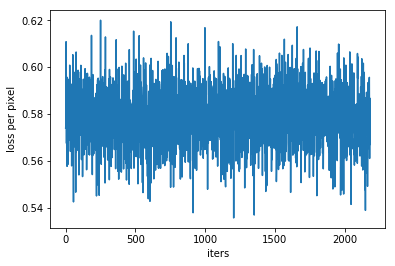

In [28]:
fig = plt.figure()
ax = plt.gca()
ax.plot(total_loss_hist)
ax.set_xlabel('iters')
ax.set_ylabel('loss per pixel')

## Exploration

In [29]:
i_dataset_denoising = 0
i_t_begin_denoising = 50
i_t_end_denoising = 600
x0_denoising = 0
y0_denoising = 0
x_window_denoising = 512
y_window_denoising = 180

post_eval = False
model_snapshot_stride = 5
model_averaging_begin_index = 400
model_averaging_end_index = i_iter // save_every

In [30]:
# baseline: n-fold spatio temporal NN averaging
n_iters_ma = 1
nnma_denoised_movie_txy = ws_denoising_list[i_dataset_denoising].padded_movie_1txy[
    0, i_t_begin_denoising:i_t_end_denoising, ...].copy()
for i_iter_ma in range(n_iters_ma):
    prev = nnma_denoised_movie_txy.copy()
    for i_t in range(1, i_t_end_denoising - i_t_begin_denoising - 1):
        nnma_denoised_movie_txy[i_t, 1:-1, 1:-1] = get_nn_spatial_mean(prev, i_t)
nnma_denoised_movie_txy = crop_center(
    nnma_denoised_movie_txy,
    target_width=ws_base_list[0].width,
    target_height=ws_base_list[0].height)

# raw
raw_movie_txy = np.zeros(
    (i_t_end_denoising - i_t_begin_denoising, ws_base_list[0].width, ws_base_list[0].height),
    dtype=np.float32)
for i_t in range(i_t_begin_denoising, i_t_end_denoising):
    raw_movie_txy[i_t - i_t_begin_denoising, ...] = \
        crop_center(
            ws_denoising_list[i_dataset_denoising].padded_movie_1txy[:, i_t, ...],
            target_width=ws_base_list[0].width,
            target_height=ws_base_list[0].height)

In [31]:
viz_pixels = [(393, 65), (490, 126)]
keep_full_denoised_movies = False

In [32]:
if post_eval:  # load saved models from disk at different iterations

    eval_states = []
    eval_state_labels = []
    for index in range(model_averaging_begin_index, model_averaging_end_index, model_snapshot_stride):
        try:
            eval_states.append(load_model_state(model_root, model_prefix, index))
            eval_state_labels.append(str(index))
        except:
            pass

    eval_states.append(get_swa_state_dict(
        model_root, model_prefix, model_averaging_begin_index, model_averaging_end_index))
    eval_state_labels.append('SWA')

    # generate denoised movies for each state
    init_state = end_to_end_denoiser.state_dict()
    denoised_movie_txy_list = []
    trunc_denoised_movie_pt_list = []
    for state, label in zip(eval_states, eval_state_labels):
        print(f'Generating denoising movie for state {label} ...')
        
        end_to_end_denoiser.load_state_dict(state)
        denoised_movie_txy = generate_denoised_movie(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            end_to_end_denoiser=end_to_end_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
        
        # keep full movie?
        if keep_full_denoised_movies:
            denoised_movie_txy_list.append(denoised_movie_txy)
            
        # only on viz pixels
        trunc_denoised_movie_pt = np.zeros((len(viz_pixels), denoised_movie_txy.shape[0]))
        for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
            trunc_denoised_movie_pt[i_pixel, :] = denoised_movie_txy[:, viz_x0, viz_y0]
        trunc_denoised_movie_pt_list.append(trunc_denoised_movie_pt)
            
    end_to_end_denoiser.load_state_dict(init_state)

    # SMA movie
    if keep_full_denoised_movies:
        denoised_movie_sma_txy = get_denoised_movie_sma_txy(denoised_movie_txy_list[:-1])
    trunc_denoised_movie_sma_pt = np.mean(trunc_denoised_movie_pt_list[:-1], axis=0)
    
else:
    
    denoised_movie_txy_list = []
    denoised_movie_txy = generate_denoised_movie(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            end_to_end_denoiser=end_to_end_denoiser,
            i_dataset=i_dataset_denoising,
            i_t_begin=i_t_begin_denoising,
            i_t_end=i_t_end_denoising,
            x0=x0_denoising,
            y0=y0_denoising,
            x_window=x_window_denoising,
            y_window=y_window_denoising)
    denoised_movie_txy_list.append(denoised_movie_txy)
    eval_state_labels = ['latest']
    denoised_movie_sma_txy = None

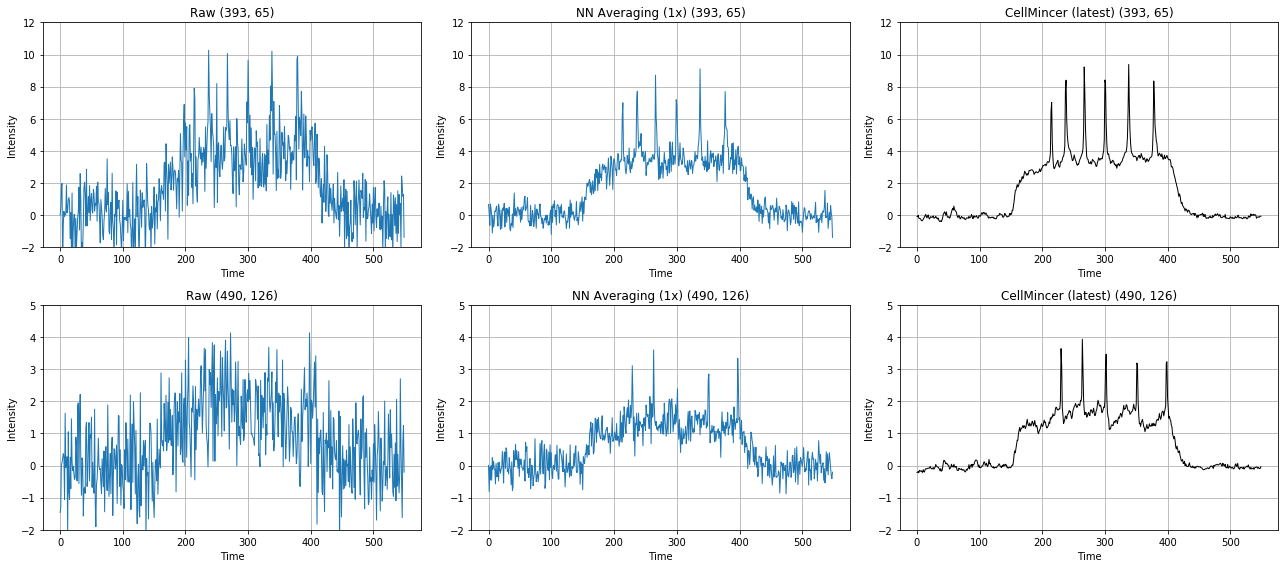

In [33]:
if post_eval:
    ncols = 5
else:
    ncols = 3

fig, axs = plt.subplots(ncols=ncols, nrows=len(viz_pixels), figsize=(6 * ncols, 4 * len(viz_pixels)))

for i_pixel, (viz_x0, viz_y0) in enumerate(viz_pixels):
    
    pixel_str = f' ({viz_x0}, {viz_y0})'
    axs[i_pixel, 0].plot(raw_movie_txy[:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 0].set_title('Raw' + pixel_str)
    axs[i_pixel, 0].set_xlabel('Time')
    axs[i_pixel, 0].set_ylabel('Intensity')
    axs[i_pixel, 0].grid()

    axs[i_pixel, 1].plot(nnma_denoised_movie_txy[1:, viz_x0, viz_y0], lw=1)
    axs[i_pixel, 1].set_title(f'NN Averaging ({n_iters_ma}x)' + pixel_str)
    axs[i_pixel, 1].set_xlabel('Time')
    axs[i_pixel, 1].set_ylabel('Intensity')
    axs[i_pixel, 1].grid()

    if post_eval:
        
        for trunc_denoised_movie_pt, label in zip(trunc_denoised_movie_pt_list[:-1], eval_state_labels[:-1]):
            axs[i_pixel, 2].plot(trunc_denoised_movie_pt[i_pixel, :], label=label, lw=1, color='black', alpha=0.05)
            axs[i_pixel, 2].set_title('CellMincer (snapshots)' + pixel_str)
            axs[i_pixel, 2].set_xlabel('Time')
            axs[i_pixel, 2].set_ylabel('Intensity')
        axs[i_pixel, 2].grid()

        axs[i_pixel, 3].plot(trunc_denoised_movie_pt_list[-1][i_pixel, :], label=label, lw=1, color='black')
        axs[i_pixel, 3].set_title('CellMincer (SWA)' + pixel_str)
        axs[i_pixel, 3].set_xlabel('Time')
        axs[i_pixel, 3].set_ylabel('Intensity')
        axs[i_pixel, 3].grid()

        axs[i_pixel, 4].plot(trunc_denoised_movie_sma_pt[i_pixel, :], label=label, lw=1, color='black')
        axs[i_pixel, 4].set_title('CellMincer (SMA)' + pixel_str)
        axs[i_pixel, 4].set_xlabel('Time')
        axs[i_pixel, 4].set_ylabel('Intensity')
        axs[i_pixel, 4].grid()
        
    else:
        
        axs[i_pixel, 2].plot(denoised_movie_txy_list[-1][:, viz_x0, viz_y0], lw=1, color='black')
        axs[i_pixel, 2].set_title('CellMincer (latest)' + pixel_str)
        axs[i_pixel, 2].set_xlabel('Time')
        axs[i_pixel, 2].set_ylabel('Intensity')
        axs[i_pixel, 2].grid()

ylim_list = [(-2, 12), (-2, 5)]
for i_pixel in range(len(viz_pixels)):
    for i_col in range(ncols):
        axs[i_pixel, i_col].set_ylim(ylim_list[i_pixel])

# # lock y limits for each viz pixel
# for i_pixel in range(len(viz_pixels)):
#     min_y_lim = np.inf
#     max_y_lim = -np.inf
#     for i_col in range(ncols):
#         ylim = axs[i_pixel, i_col].get_ylim()
#         min_y_lim = min(min_y_lim, ylim[0])
#         max_y_lim = max(max_y_lim, ylim[1])
#     for i_col in range(ncols):
#         axs[i_pixel, i_col].set_ylim((min_y_lim, max_y_lim))

plt.tight_layout()
# plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}.pdf')

In [34]:
# viz_i_t = 350

# fig, ax = new_fig()
# im = ax.imshow(denoised_movie_txy[viz_i_t, ...].T, origin='lower')
# for (viz_x0, viz_y0) in viz_pixels:
#     ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
# plt.tight_layout()
# # plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_denoised_snapshot.pdf')

# fig, ax = new_fig()
# im = ax.imshow(raw_movie_txy[viz_i_t, ...].T, origin='lower')
# for (viz_x0, viz_y0) in viz_pixels:
#     ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
# plt.tight_layout()
# # plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_raw_snapshot.pdf')

# fig, ax = new_fig()
# im = ax.imshow(ws_base_list[i_dataset_denoising].movie_t_corr_xy.T, origin='lower')
# for (viz_x0, viz_y0) in viz_pixels:
#     ax.plot([viz_x0], [viz_y0], marker='.', markersize=16, color='red')
# plt.tight_layout()
# # plt.savefig(f'./out/{opto_mov_prefixes[i_dataset_denoising]}_{model_prefix}_corr.pdf')

## Visualize the learning dynamics

In [525]:
%matplotlib inline

import matplotlib.animation as animation
import time as time

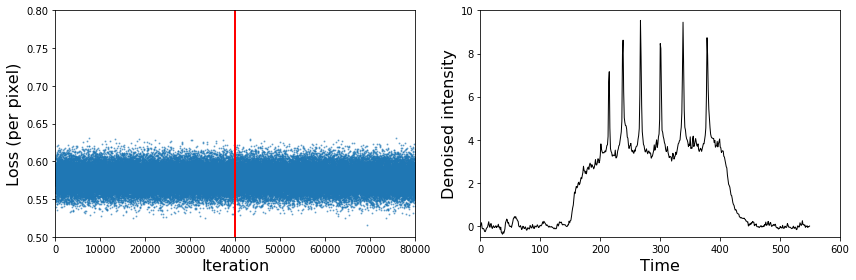

In [527]:
fig, axs = plt.subplots(ncols=2, figsize=(12, 4))
i_pixel = 0

def update_frame(snapshot_index):
    snapshot_i_iter = (model_averaging_begin_index + model_snapshot_stride * snapshot_index) * save_every
    axs[0].clear()
    axs[0].scatter(np.arange(len(total_loss_hist)), total_loss_hist, s=1, alpha=0.5)
    axs[0].plot([snapshot_i_iter, snapshot_i_iter], [0.5, 0.8], lw=2, color='red')
    axs[1].clear()
    axs[1].plot(trunc_denoised_movie_pt_list[snapshot_index][i_pixel, :], lw=1, color='black')
    
    axs[0].set_ylim((0.5, 0.8))
    axs[0].set_xlim((0, len(total_loss_hist)))
    axs[0].set_ylabel('Loss (per pixel)', fontsize=16)
    axs[0].set_xlabel('Iteration', fontsize=16)

    axs[1].set_ylim((-0.5, 10.))
    axs[1].set_xlim((0, 600))
    axs[1].set_ylabel('Denoised intensity', fontsize=16)
    axs[1].set_xlabel('Time', fontsize=16)

    fig.tight_layout()


update_frame(0)
ani = animation.FuncAnimation(fig, update_frame, len(trunc_denoised_movie_pt_list))
writer = animation.writers['ffmpeg'](fps=30)
ani.save('demo.mp4', writer=writer, dpi=100)

## Generate denoised datasets

In [533]:
from time import time

In [173]:
model_prefix_to_load = 'rc2_t11_relu__unreg'
model_index = 10
logging.warning(f'Loading a pre-trained model ...')
end_to_end_denoiser.load_state_dict(load_model_state(model_root, model_prefix_to_load, model_index))

<All keys matched successfully>

In [35]:
for i_dataset in range(len(ws_base_list)):

    t_mid = (denoiser_config['t_order'] - 1) // 2
    denoised_movie_txy = np.zeros_like(ws_base_list[i_dataset].movie_txy)
    log_frequency = 500
    total_frames = ws_base_list[i_dataset].n_frames - t_mid
    t0 = time()

    for i_t in range(t_mid, total_frames):

        denoising_input_data = generate_input_for_single_frame_denoising(
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            i_dataset=i_dataset,
            i_t=i_t,
            t_order=denoiser_config['t_order'],
            x0=0,
            y0=0,
            x_window=ws_base_list[i_dataset].width,
            y_window=ws_base_list[i_dataset].height,
            device=device,
            dtype=dtype)

        denoised_frame_xy = denoise_end_to_end(
            denoising_input_data,
            ws_base_list=ws_base_list,
            ws_denoising_list=ws_denoising_list,
            end_to_end_denoiser=end_to_end_denoiser)

        denoised_movie_txy[i_t, ...] = denoised_frame_xy.cpu().numpy()

        if (i_t - t_mid) % log_frequency == 0 and i_t > t_mid:
            fps = log_frequency / (time() - t0)
            t0 = time()
            print(f'[{opto_mov_prefixes[i_dataset]}] processed {i_t - t_mid}/{total_frames} frames ({fps:.3} fps)...')

    denoised_movie_txy[:t_mid, ...] = denoised_movie_txy[t_mid, ...]
    denoised_movie_txy[total_frames:, ...] = denoised_movie_txy[total_frames - 1, ...]

    np.save(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy"),
        denoised_movie_txy.transpose(0, 2, 1))

[D1_FOV3_W2_at135105] processed 500/6297 frames (1.15e+02 fps)...
[D1_FOV3_W2_at135105] processed 1000/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 1500/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 2000/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 2500/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 3000/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 3500/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 4000/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 4500/6297 frames (1.16e+02 fps)...
[D1_FOV3_W2_at135105] processed 5000/6297 frames (1.15e+02 fps)...
[D1_FOV3_W2_at135105] processed 5500/6297 frames (1.15e+02 fps)...
[D1_FOV3_W2_at135105] processed 6000/6297 frames (1.16e+02 fps)...
[D4_FOV2_W2_at171603] processed 500/6297 frames (91.5 fps)...
[D4_FOV2_W2_at171603] processed 1000/6297 frames (1.17e+02 fps)...
[D4_FOV2_W2_at171603] processed 1500/6297 frames (1.16e+02 fps)...
[

## Make movies

In [4]:
import skvideo
from skvideo import io as skio
from matplotlib.colors import Normalize

In [5]:
model_prefix = 'rc3_t11_relu__unreg'
n_datasets = len(opto_mov_prefixes)

In [10]:
for i_dataset in range(n_datasets):
    # write denoised movie
    denoised_movie_txy = np.load(
        os.path.join(
            output_path,
            opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.npy")).transpose(0, 2, 1)

    norm = Normalize(vmin=-1.0, vmax=10., clip=True)
    denoised_movie_txy = (255 * norm(denoised_movie_txy)[..., None]).astype(np.uint8)

    movie_out_path = os.path.join(
        output_path,
        opto_mov_prefixes[i_dataset] + "__" + model_prefix + "__denoised.avi")

    writer = skio.FFmpegWriter(
        movie_out_path,
        outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

    for i in range(4350, 4800):
            writer.writeFrame(denoised_movie_txy[i, ...].T)
    writer.close()

In [ ]:
# write raw movie
movie_out_path = os.path.join(
    output_path,
    opto_mov_prefixes[i_dataset] + '_raw.avi')

writer = skvideo.io.FFmpegWriter(
    movie_out_path,
    outputdict={'-vcodec': 'rawvideo', '-pix_fmt': 'yuv420p', '-r': '60'})

for i in range(4350, 4800):
        writer.writeFrame(ws_base_list[i_dataset].movie_txy[i, ...].T)
writer.close()